#### 목표 수출증가율을 가져오고 한국 기업들의 매출_재무정보를 대칭시켜 기업 매출을 예측한다

- 회귀분석 . UNIVERSIAL SARIMA를 이용해 보자

In [7]:
import pandas as pd
from sqlalchemy import create_engine
from DATA.stock_invest_function import fetch_table_data
import statsmodels.api as sm

In [3]:
def compute_quarterly_yoy_growth(trade_df: pd.DataFrame) -> pd.DataFrame:
    """
    월별 수출 데이터를 분기별로 집계하고 전년 동분기 대비 증감률을 계산합니다.

    Parameters:
    - trade_df (pd.DataFrame): 원본 데이터프레임. 'date', 'root_hs_code', 'value' 열 포함.

    Returns:
    - pd.DataFrame: 'root_hs_code', 'quarter', 'value', 'yoy_growth' 포함한 결과
    """
    # 날짜 형식 변환
    trade_df['date'] = pd.to_datetime(trade_df['date'])

    # 분기 종료일 추출 (normalize로 시간 제거)
    trade_df['quarter'] = trade_df['date'].dt.to_period('Q').dt.end_time.dt.normalize()

    # 분기별 합계
    quarterly_sum = (
        trade_df.groupby(['root_hs_code', 'quarter'])['value']
        .sum()
        .reset_index()
    )

    # 전년 동분기 대비 증감률 계산
    quarterly_sum['yoy_growth'] = (
        quarterly_sum.groupby('root_hs_code')['value']
        .pct_change(periods=4)
    )

    quarterly_sum.rename(columns={'quarter': 'date'}, inplace=True)

    return quarterly_sum

def add_yoy_growth(df, value_column='value', group_column='root_hs_code', date_column='date'):
    """
    root_hs_code별로 value 컬럼의 연간 증가율을 계산하여 새로운 컬럼으로 추가합니다.
    """
    df = df.copy()
    df[date_column] = pd.to_datetime(df[date_column])
    df.sort_values(by=[group_column, date_column], inplace=True)

    # YoY (12개월 전 대비 비율 변화율) 계산
    df[f'{value_column}_yoy'] = (
        df.groupby(group_column)[value_column]
        .transform(lambda x: x.pct_change(periods=12))
    )

    return df

def merge_and_clean_trade_sales_df(df_indicator: pd.DataFrame, df_actual: pd.DataFrame) -> pd.DataFrame:
    """
    indicator_yoy_growth와 yoy_growth 데이터를 date 기준으로 병합하고, 결측치 제거

    Parameters:
    - df_indicator (pd.DataFrame): 'date', 'indicator_yoy_growth' 포함
    - df_actual (pd.DataFrame): 'date', 'yoy_growth' 포함

    Returns:
    - pd.DataFrame: 'date', 'indicator_yoy_growth', 'yoy_growth'만 포함된 NaN 없는 데이터
    """
    # 필요한 컬럼만 추출
    df_indicator = df_indicator[['date', 'indicator_yoy_growth']]
    df_actual = df_actual[['date', 'yoy_growth']]

    # 병합 (inner join: 공통 date만 남음)
    merged_df = pd.merge(df_indicator, df_actual, on='date', how='inner')

    # NaN 제거
    clean_df = merged_df.dropna()

    return clean_df

### 1. 데이터 전처리

In [4]:
# DB 접속 정보 설정
db_info = {
    'user': 'stox7412',         # 예: 'root'
    'password': 'Apt106503!~', # 예: '1234'
    'host': 'hystox74.synology.me',         # 예: 'localhost' 또는 IP
    'port': '3307',              # 기본 포트는 보통 3306
    'database': 'investar'        # 예: 'trade_data'
}

fs_df = fetch_table_data(db_info, "Korea_FS_data")
fs_df.rename(columns={'Date': 'date'}, inplace=True)
trade_df = fetch_table_data(db_info, "korea_monthly_trade_act_forecast_data")

✅ 'Korea_FS_data' 테이블에서 537251건의 데이터를 가져왔습니다.
✅ 'korea_monthly_trade_act_forecast_data' 테이블에서 121600건의 데이터를 가져왔습니다.


In [5]:
df_combined_with_yoy = add_yoy_growth(trade_df)

company_num = 490

# 1. 예측 데이터만 필터링하고 NaN 제거
df_forecast_only = df_combined_with_yoy[
    (df_combined_with_yoy['is_forecast'] == 1) &
    (df_combined_with_yoy['value_yoy'].notna())
]

# 2. root_hs_code별 평균 YoY 증가율 계산
avg_yoy_by_code = (
    df_forecast_only
    .groupby('root_hs_code')['value_yoy']
    .mean()
    .reset_index()
    .rename(columns={'value_yoy': 'avg_forecast_yoy'})
)

# 3. 수출 증가율 기준으로 상위 10개 추출
top_company_codes = avg_yoy_by_code.sort_values(by='avg_forecast_yoy', ascending=False).head(company_num)

In [10]:
ticker = 'A267270'
hs_code  = '842952'
target_fs = fs_df[(fs_df['Symbol'] == ticker) & (fs_df['indicator'] == '매출액(천원)')].copy()

quarter_trade_data = compute_quarterly_yoy_growth(trade_df)
target_trade_data =quarter_trade_data[quarter_trade_data['root_hs_code'] == hs_code].copy()

# 문자열로 되어 있는 value를 float으로 변환
target_fs['value'] = pd.to_numeric(target_fs['value'], errors='coerce')
target_fs['indicator_yoy_growth'] =target_fs['value'].pct_change(periods=4, fill_method=None)
target_sales_data = target_fs

sales_trade_df = merge_and_clean_trade_sales_df(target_sales_data, target_trade_data)
print(sales_trade_df.head())

         date  indicator_yoy_growth  yoy_growth
45 2018-06-30              0.350553    0.221872
46 2018-09-30              0.158442    0.104030
47 2018-12-31              0.135633   -0.019351
48 2019-03-31             -0.142384   -0.082649
49 2019-06-30             -0.089258   -0.136543


In [8]:
# 독립 변수 (X), 상수항 추가
X = sales_trade_df['yoy_growth']
X = sm.add_constant(X)  # 상수항 추가 (intercept)

# 종속 변수 (Y)
y = sales_trade_df['indicator_yoy_growth']

# 회귀모형 적합
model = sm.OLS(y, X).fit()

# 결과 출력
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     indicator_yoy_growth   R-squared:                       0.466
Model:                              OLS   Adj. R-squared:                  0.448
Method:                   Least Squares   F-statistic:                     25.35
Date:                  Thu, 12 Jun 2025   Prob (F-statistic):           2.30e-05
Time:                          14:20:43   Log-Likelihood:                 16.616
No. Observations:                    31   AIC:                            -29.23
Df Residuals:                        29   BIC:                            -26.36
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0487      0.026

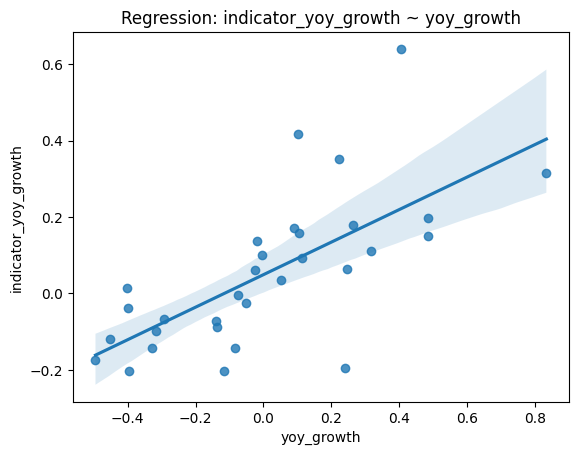

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.regplot(x='yoy_growth', y='indicator_yoy_growth', data=clean_data)
plt.title('Regression: indicator_yoy_growth ~ yoy_growth')
plt.show()

In [116]:
# 1. 회귀모형 적합 (기존 clean_data 사용)
X = sm.add_constant(clean_data['yoy_growth'])  # 상수항 추가
y = clean_data['indicator_yoy_growth']
model = sm.OLS(y, X).fit()

# 2. 계수 자동 추출
intercept = model.params['const']
slope = model.params['yoy_growth']

print(f"회귀식: indicator_yoy_growth = {intercept:.4f} + {slope:.4f} * yoy_growth")

# 3. 예측할 target 날짜 정의
target_dates = ['2025-06-30', '2025-09-30', '2025-12-31', '2026-03-31']

# 4. 날짜 형식 변환
target_trade_data['date'] = pd.to_datetime(target_trade_data['date'])

# 5. 대상 데이터 추출
target_yoy = target_trade_data[target_trade_data['date'].isin(pd.to_datetime(target_dates))].copy()

# 6. 예측값 계산
target_yoy['predicted_indicator_yoy_growth'] = intercept + slope * target_yoy['yoy_growth']
predicted_yoy_df = target_yoy

# 7. 결과 출력
print(target_yoy[['date', 'yoy_growth', 'predicted_indicator_yoy_growth']])

회귀식: indicator_yoy_growth = 0.0487 + 0.4257 * yoy_growth
            date  yoy_growth  predicted_indicator_yoy_growth
26165 2025-06-30    0.246179                        0.153506
26166 2025-09-30    0.317420                        0.183834
26167 2025-12-31    0.484871                        0.255121
26168 2026-03-31    0.323646                        0.186484


C:\Users\MetaM\AppData\Local\Temp\ipykernel_20840\347890641.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_trade_data['date'] = pd.to_datetime(target_trade_data['date'])


In [117]:
# 1. 날짜 문자열을 datetime으로 변환
target_sales_data['date'] = pd.to_datetime(target_sales_data['date'])
predicted_yoy_df['date'] = pd.to_datetime(predicted_yoy_df['date'])  # 예측 결과 DataFrame 이름은 수정 가능

# 2. 기준 매출 날짜 → 매핑용
base_dates = ['2024-06-30', '2024-09-30', '2024-12-31', '2025-03-31']
growth_dates = ['2025-06-30', '2025-09-30', '2025-12-31', '2026-03-31']

# 3. 결과 저장 리스트
future_sales_estimates = []

# 4. 매핑하면서 예측 매출 계산
for base_date, growth_date in zip(base_dates, growth_dates):
    base_date = pd.to_datetime(base_date)
    growth_date = pd.to_datetime(growth_date)

    # 기준 매출
    base_value = target_sales_data.loc[target_sales_data['date'] == base_date, 'value'].values
    growth_rate = predicted_yoy_df.loc[predicted_yoy_df['date'] == growth_date, 'predicted_indicator_yoy_growth'].values

    # 예외 처리: 값이 없으면 스킵
    if len(base_value) == 0 or len(growth_rate) == 0:
        continue

    estimated_sales = base_value[0] * (1 + growth_rate[0])

    future_sales_estimates.append({
        'date': growth_date,
        'base_sales_date': base_date,
        'base_sales_value': base_value[0],
        'predicted_growth': growth_rate[0],
        'estimated_future_sales': estimated_sales
    })

# 5. 결과 DataFrame 생성
future_sales_df = pd.DataFrame(future_sales_estimates)
print(future_sales_df)

        date base_sales_date  base_sales_value  predicted_growth  \
0 2025-06-30      2024-06-30       852993368.0          0.153506   
1 2025-09-30      2024-09-30       816811834.0          0.183834   
2 2025-12-31      2024-12-31       789146573.0          0.255121   
3 2026-03-31      2025-03-31       906839913.0          0.186484   

   estimated_future_sales  
0            9.839327e+08  
1            9.669696e+08  
2            9.904744e+08  
3            1.075951e+09  


In [118]:
future_sales_df.to_csv(f'{ticker}_predicted_sales.csv', index=False)

In [ ]:
%%sql
